# Deep Learning on Malawi MapSwipe satellite imagery

### Udacity Capstone Project
February 20, 2018

### By David Ghan

This notebook will demonstrate the code used for exploring and modeling on a MapSwipe satellite imagery classification project. The project took place in Malawi and the purpose of this notebook is to use the available data that classified by users as having or not having a target variable. In this project, that variable is building or structures.

The notebook will be organized in four sections: 
1. Image import and cleaning
2. Data exploration and analysis
3. Benchmark model
4. Scratch model
5. InceptionV3 model
6. VGG-16 model
7. Prediction analysis

## Image import and cleaning

These libraries will be used to import our imagery data, partition into train, validation and test sets, and convert into the appropriate tensors sizes for our deep learning models:

In [2]:
from keras.preprocessing import image
from keras.utils import np_utils
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split 
import numpy as np
from glob import glob
from PIL import ImageFile                 
ImageFile.LOAD_TRUNCATED_IMAGES = True 
import pandas as pd
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.
/home/aind2/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


The following will import, partition and convert our data. Our conversion will be to a 4D tensor with a shape of (n, 256, 256, 3). The first value is the number of images, the second and third values are the horizontal and vertical pixels of the image, and the last value is the number of channels for each image. Since our images are in color, we have three channels (RGB).

In [3]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

def load_dataset(path):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    image_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return image_files, image_targets

targets = [item[13:-1] for item in glob("data/malawi/train/*/")]
malawi_bulk_files, malawi_bulk_targets = load_dataset('data/malawi/train')
malawi_valid_files, malawi_valid_targets = load_dataset('data/malawi/valid')
malawi_train_files, malawi_test_files, malawi_train_targets, malawi_test_targets = train_test_split(malawi_bulk_files,
                                                                                                    malawi_bulk_targets,
                                                                                                    test_size=0.2,
                                                                                                    random_state=1987)

print('There are %s total Malawi map images.\n' % len(np.hstack([malawi_train_files, malawi_valid_files, malawi_test_files])))
print('There are %d training Malawi map images.' % len(malawi_train_files))
print('There are %d validation Malawi map images.' % len(malawi_valid_files))
print('There are %d test Malawi map images.'% len(malawi_test_files))
print('There are %d total map classifications.'% len(targets))

malawi_train_tensors = paths_to_tensor(malawi_train_files).astype('float32')/255
malawi_valid_tensors = paths_to_tensor(malawi_valid_files).astype('float32')/255
malawi_test_tensors = paths_to_tensor(malawi_test_files).astype('float32')/255

There are 9000 total Malawi map images.

There are 6400 training Malawi map images.
There are 1000 validation Malawi map images.
There are 1600 test Malawi map images.
There are 2 total map classifications.


Now we have our images in the correct tensor format for learning using Keras with the TensorFlow backend. Next I want to manipulate some labels to be used later for plotting samples and calculating model performances:

In [4]:
# target stats
target_labels = pd.DataFrame({"built":[1,0],"empty":[0,1]})

def get_label(row):
    for i in target_labels.columns:
        if row[i]==1:
            return i
 
train_df = pd.DataFrame(malawi_train_targets, columns= ('built','empty'))
train_target_df = train_df.apply(get_label, axis=1)
valid_df = pd.DataFrame(malawi_valid_targets, columns= ('built','empty'))
valid_target_df = valid_df.apply(get_label, axis=1)
test_df = pd.DataFrame(malawi_test_targets, columns= ('built','empty'))
test_target_df = test_df.apply(get_label, axis=1)

## Data Exploration and Analysis

We will first explore our label distributions for each dataset. This will help us decide which metric would best apply to our model performances:

In [5]:
train_count = np.unique(train_target_df, return_counts=True)
valid_count = np.unique(valid_target_df, return_counts=True)
test_count = np.unique(test_target_df, return_counts=True)

print('There are %s "built" and %s "empty" images in the train set.' % (train_count[1][0], train_count[1][1]))
print('There are %s "built" and %s "empty" images in the valid set.' % (valid_count[1][0], valid_count[1][1]))
print('There are %s "built" and %s "empty" images in the test set.' % (test_count[1][0], test_count[1][1]))

There are 3212 "built" and 3188 "empty" images in the train set.
There are 500 "built" and 500 "empty" images in the valid set.
There are 788 "built" and 812 "empty" images in the test set.


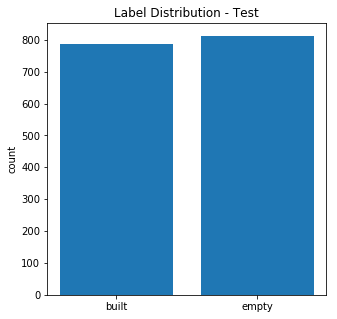

In [6]:
plt.figure(figsize=(5,5)) 
df = pd.DataFrame(malawi_test_targets, columns=('built','empty'))
names = ('built','empty')
built_count = df['built'].sum()
empty_count = df['empty'].sum()

plt.bar(np.arange(len(names)), [built_count, empty_count])
plt.ylabel('count')
plt.xticks(np.arange(len(names)), names)
plt.title('Label Distribution - Test')
plt.show()

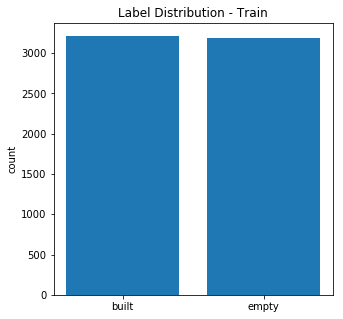

In [7]:
plt.figure(figsize=(5,5)) 
df = pd.DataFrame(malawi_train_targets, columns=('built','empty'))
names = ('built','empty')
built_count = df['built'].sum()
empty_count = df['empty'].sum()

plt.bar(np.arange(len(names)), [built_count, empty_count])
plt.ylabel('count')
plt.xticks(np.arange(len(names)), names)
plt.title('Label Distribution - Train')
plt.show()

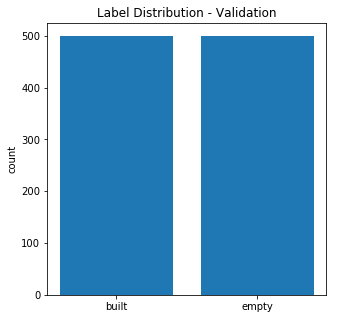

In [8]:
plt.figure(figsize=(5,5)) 
df = pd.DataFrame(malawi_valid_targets, columns=('built','empty'))
names = ('built','empty')
built_count = df['built'].sum()
empty_count = df['empty'].sum()

plt.bar(np.arange(len(names)), [built_count, empty_count])
plt.ylabel('count')
plt.xticks(np.arange(len(names)), names)
plt.title('Label Distribution - Validation')
plt.show()

The distribution of our two labels in each section seems to be evenly distributed. Because of this, we are able to use accuracy as a metric for our model performance. However, we will also explore confusion matrices and the log loss for a wider view of our models' performances.

#### Bad_Imagery

This section produces a sample the removed label "bad_imagery". The idea behind this label was to classify images as being unable to classify due to obstructions (such as cloud cover) or image quality. As we see below, Our sample seem to clearly demonstrate the correct label should have been "empty", since there are no obstructions and the images clearly do not contain any buildings that would justify them being classified as "built" images.

In [11]:
from PIL import Image
import glob
bad_imagery = []
for filename in glob.glob('data/bad_imagery/*.jpg'):
    im=Image.open(filename)
    bad_imagery.append(im)

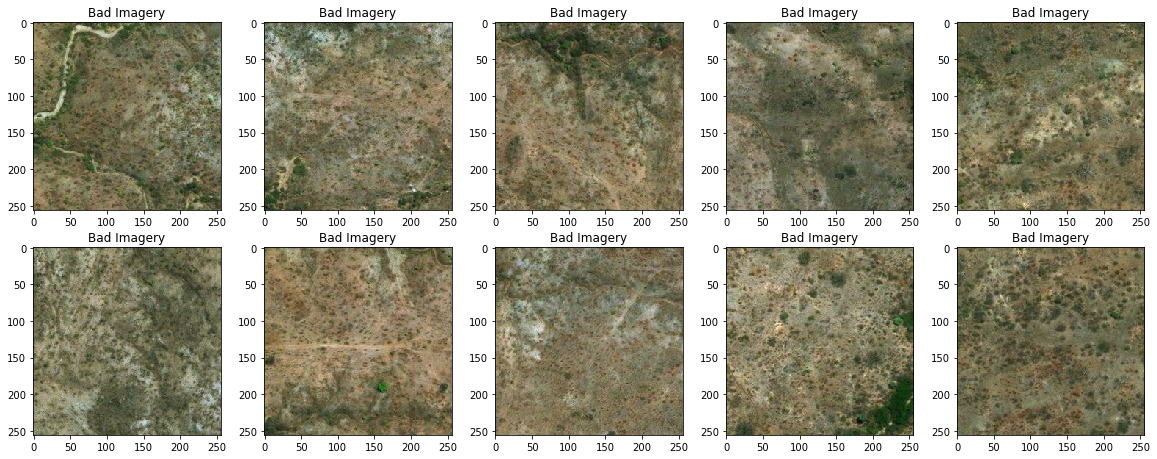

In [12]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.title('Bad Imagery')
    plt.imshow(bad_imagery[i])

#### Exploring our images

This code produces a sample of our images and labels them according to their classification.

In [13]:
y = pd.DataFrame(malawi_train_targets)
y = pd.Series(y[0])
pos_y = y[y==1]
built = pos_y.index
neg_y = y[y==0]
empty = neg_y.index

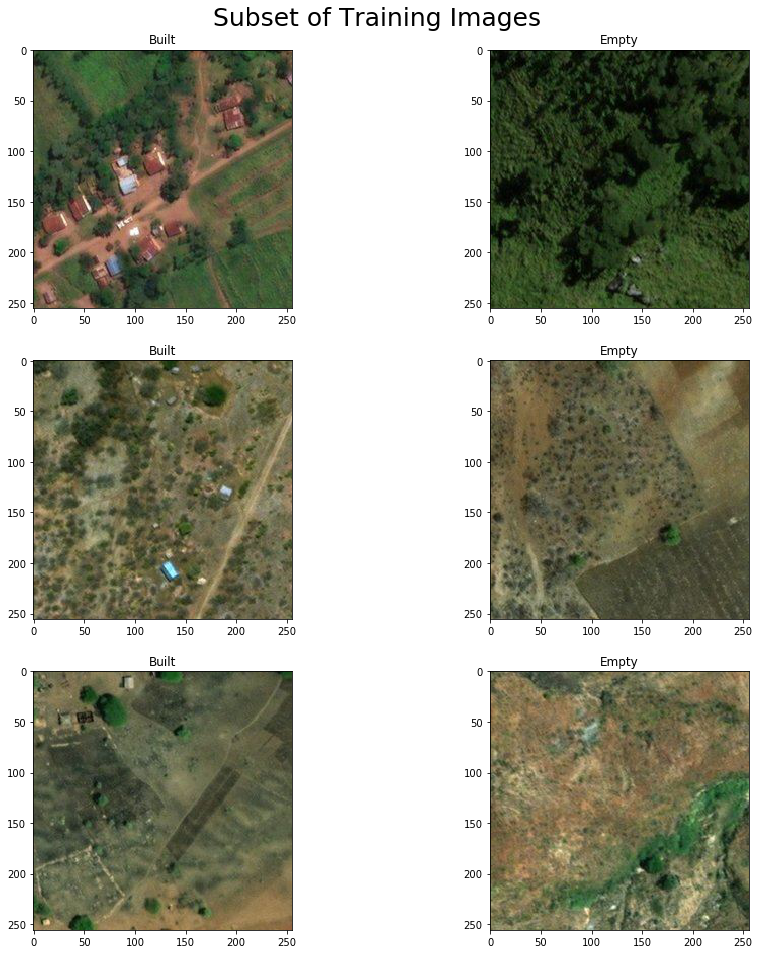

In [14]:
fig = plt.figure(figsize=(15,15))
for i in range(6):
    plt.subplot(3,2,i+1)
    if y[i]==1:
        plt.title('Built')
    else:
        plt.title('Empty')
    plt.imshow(malawi_train_tensors[i])
fig.suptitle('Subset of Training Images', fontsize=25)
plt.subplots_adjust(top=.94)
plt.show()

We see here that the "built" images have buildings or structures that are clearly visible. While looking at the "empty" images, I suspect our model might confuse anomolies like rock formations as buildings. This is something to keep in mind when we examine our models' performances.

Now I want to see what our RGB distribution looks like across this same subset. I also want to get a summary of our RGB levels between our "empty" and "built" images.

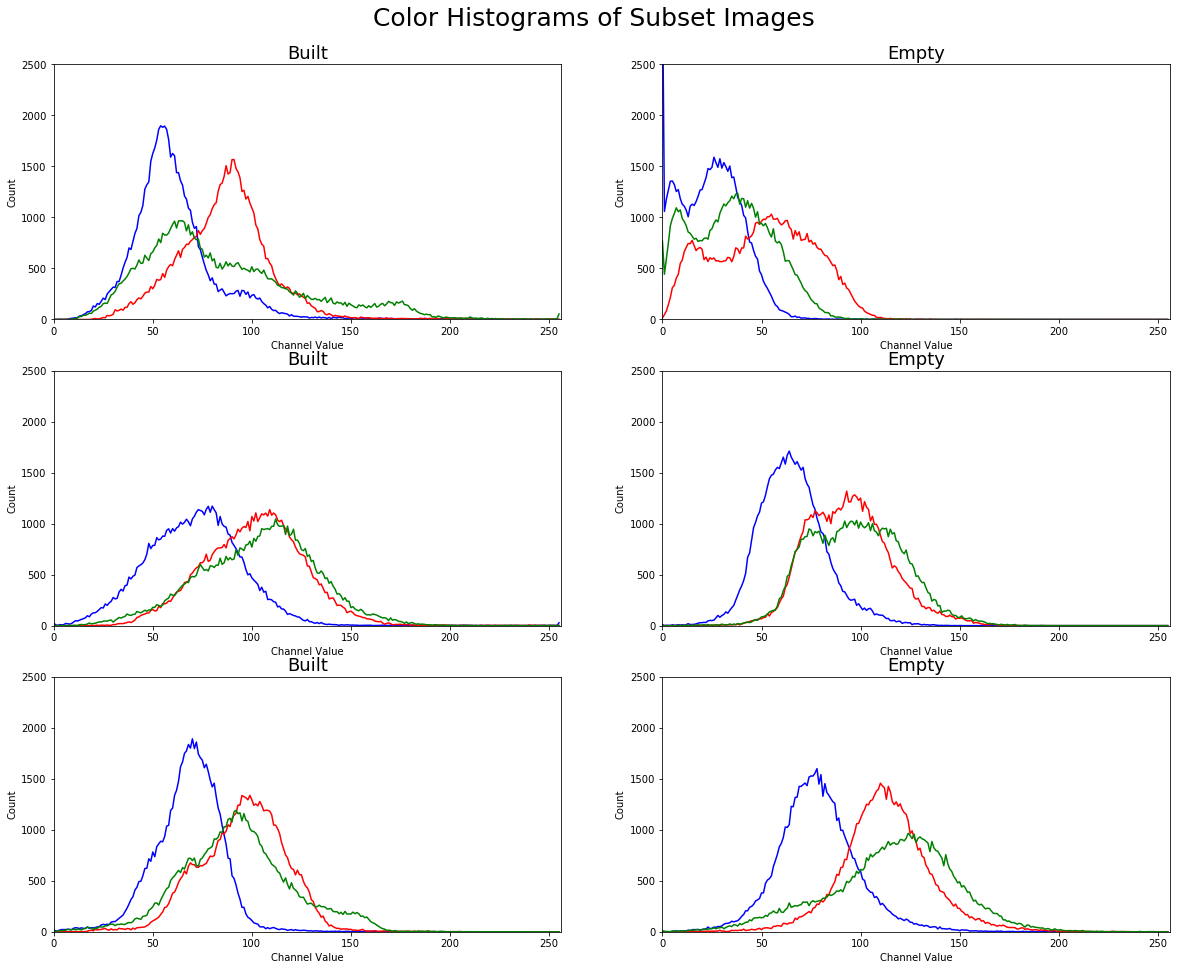

In [15]:
fig = plt.figure(figsize=(20,20))
color = ('b', 'r', 'g')
for i in range(6):
    plt.subplot(4,2,i+1)
    img = cv2.imread(malawi_train_files[i])
    plt.ylim(0, 2500)
    if y[i]==1:
        plt.title('Built', fontsize = 18)
    else:
        plt.title('Empty', fontsize = 18)
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.ylabel('Count')
    plt.xlabel('Channel Value')
fig.suptitle('Color Histograms of Subset Images', fontsize=25)
plt.subplots_adjust(top=.94)
plt.show()

#### Normalized color distribution summary statistics - Built

In [16]:
print('red channel: min/mean/median/std/max = %.2f/%.2f/%.2f/%.2f'%(malawi_train_tensors[built,:,:,0].min(),
    malawi_train_tensors[built,:,:,0].mean(), malawi_train_tensors[built,:,:,0].std(), malawi_train_tensors[built,:,:,0].max()))
print('green channel: min/mean/median/std/max = %.2f/%.2f/%.2f/%.2f'%(malawi_train_tensors[built,:,:,1].min(),
    malawi_train_tensors[built,:,:,1].mean(), malawi_train_tensors[built,:,:,1].std(), malawi_train_tensors[built,:,:,1].max()))
print('blue channel: min/mean/median/std/max = %.2f/%.2f/%.2f/%.2f'%(malawi_train_tensors[built,:,:,2].min(),
    malawi_train_tensors[built,:,:,2].mean(), malawi_train_tensors[built,:,:,2].std(), malawi_train_tensors[built,:,:,2].max()))

red channel: min/mean/median/std/max = 0.00/0.38/0.14/1.00
green channel: min/mean/median/std/max = 0.00/0.38/0.11/1.00
blue channel: min/mean/median/std/max = 0.00/0.27/0.10/1.00


#### Normalized color distribution summary statistics - Empty

In [17]:
print('red channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(malawi_train_tensors[empty,:,:,0].min(),
    malawi_train_tensors[empty,:,:,0].mean(), malawi_train_tensors[empty,:,:,0].std(), malawi_train_tensors[empty,:,:,0].max()))
print('green channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(malawi_train_tensors[empty,:,:,1].min(),
    malawi_train_tensors[empty,:,:,1].mean(), malawi_train_tensors[empty,:,:,1].std(), malawi_train_tensors[empty,:,:,1].max()))
print('blue channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(malawi_train_tensors[empty,:,:,2].min(),
    malawi_train_tensors[empty,:,:,2].mean(), malawi_train_tensors[empty,:,:,2].std(), malawi_train_tensors[empty,:,:,2].max()))

red channel: min/mean/std/max = 0.00/0.33/0.13/1.00
green channel: min/mean/std/max = 0.00/0.34/0.11/1.00
blue channel: min/mean/std/max = 0.00/0.24/0.10/1.00


## Benchmark Model (random choice)

My benchmark model is coded below as a random choice model

In [18]:
from sklearn import metrics
test_targets = pd.DataFrame(malawi_test_targets)
test_targets = pd.Series(test_targets[0])
malawi_test_targets_list = list(test_targets.astype(int))

In [19]:
random = pd.DataFrame(np.random.uniform(0,1, size=(1600,1)))
random[1] = 1-random[0]
random_series = random[0]
baseline_predictions_array = np.asarray(random)

In [20]:
threshold = 0.5
baseline_predictions_binary = (baseline_predictions_array < threshold).astype(np.int)
baseline_predictions_list = np.array(pd.DataFrame(baseline_predictions_binary)[0])

In [21]:
benchmark_acc = np.sum(np.array(baseline_predictions_list[0])==np.argmax(malawi_test_targets, axis=1))/len(baseline_predictions_list)
benchmark_logloss = metrics.log_loss(y_pred=baseline_predictions_array, y_true=malawi_test_targets)

In [22]:
print('Benchmark Accuracy Score is %s%%.' % round((100*benchmark_acc), 2))
print('Benchmark Log Loss is %s.' % benchmark_logloss)

Benchmark Accuracy Score is 50.75%.
Benchmark Log Loss is 1.02562981436.


## Scratch Model

The plot function below will help us visualize our model performance over each epoch, measured by our loss and accuracy:

In [23]:
def plot_performance(history):
    plt.figure(figsize=(15,15))
    plt.subplot(211)  
    plt.plot(history.history['acc'])  
    plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    plt.show()

The following libraries are used for multiple layers in our scratch model as well as our metrics for calculating performance:

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint  
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

Our scratch model takes the input shape of our dataset after it's converted to a 4D tensor. As mentioned during our data conversion step, the shape is (n, 256, 256, 3):

In [10]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=malawi_train_tensors.shape[1:]))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(2, activation='sigmoid'))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 59, 128)       73856     
__________

In [10]:
from keras.utils import plot_model
plot_model(model1, to_file='model2.png')

For the scratch model, I will be using image augmentation. This consists of shifting and flipping images. This will help in the training of our images and improve our model performance by adding to our training data, in a sense. The following code augments the train and validation data that will be used in training:

In [7]:
datagen_train = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

datagen_valid = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True) 

datagen_train.fit(malawi_train_tensors)
datagen_valid.fit(malawi_valid_tensors)

Here is where we will tune our parameters. Specifically, I will explore the learning rate (lr), optimizer used for training, and changing our batch sizes.

In [11]:
checkpointer = ModelCheckpoint(filepath='weights.best.model1.hdf5', 
                               verbose=1, save_best_only=True)

adam = optimizers.Adam(lr = 0.001)
model1.compile(optimizer="adam",loss="binary_crossentropy",metrics =["accuracy"])

epochs=20
batch_size=32

This code is used to specifically train augmented image datasets, which we fit in the cells above.

In [ ]:
model1_history = model1.fit_generator(datagen_train.flow(malawi_train_tensors, malawi_train_targets, batch_size=batch_size), 
                    steps_per_epoch=malawi_train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(malawi_valid_tensors, malawi_valid_targets, batch_size=batch_size),
                    validation_steps=malawi_valid_tensors.shape[0] // batch_size)

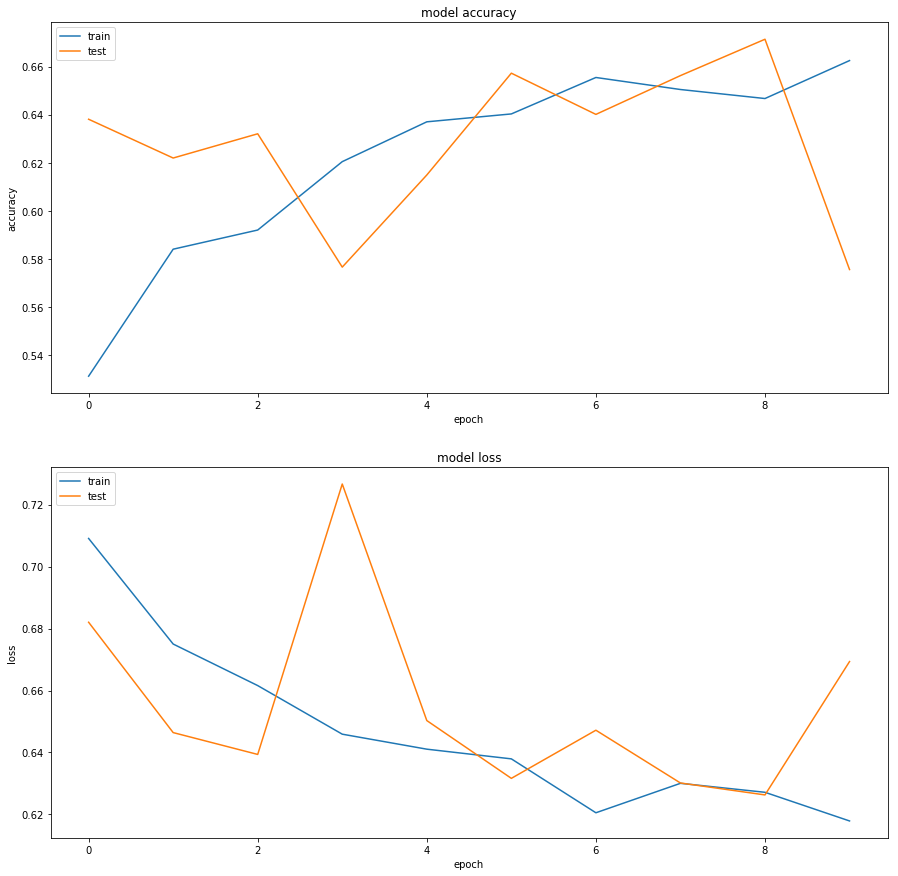

In [10]:
plot_performance(model1_history)

In [56]:
model1.load_weights('weights.best.model1.hdf5')

model1_predictions = [np.argmax(model1.predict(np.expand_dims(tensor, axis=0))) for tensor in malawi_test_tensors]
scratch_predictions = model1.predict(malawi_test_tensors)
test_accuracy = 100*np.sum(np.array(model1_predictions)==np.argmax(malawi_test_targets, axis=1))/len(model1_predictions)
log_loss = metrics.log_loss(y_pred=scratch_predictions, y_true=malawi_test_targets)
print('Test accuracy: %.4f%%' % test_accuracy)
print('Log loss: %.4f' % log_loss)

Test accuracy: 65.5000%
Log loss: 0.6275


## InceptionV3 Model

To apply transfer learning with the InceptionV3 model, I will import the model as it is pre-trained on the ImageNet dataset.

In [13]:
from keras.applications import InceptionV3

In [7]:
inception_model = InceptionV3(include_top=False, weights='imagenet')

In [9]:
from keras.utils import plot_model
plot_model(inception_model, to_file='inception_model.png')

Now we can take our pre-trained model and use it to extract the bottleneck features of our Malawi image data. This is computationally expenseive but is only done one time.

In [33]:
train = inception_model.predict(malawi_train_tensors)
valid = inception_model.predict(malawi_valid_tensors)
test = inception_model.predict(malawi_test_tensors)

Lets save our bottleneck features so that we can load in the future at any time without having to do the previous step again:

In [34]:
np.savez(file='inception_features', 
         train=train, 
         valid=valid,
         test=test)

Now we can use the following code to load our bottleneck features at any time:

In [28]:
bottleneck_features = np.load('inception_features.npz')
inception_train = bottleneck_features['train']
inception_valid = bottleneck_features['valid']
inception_test = bottleneck_features['test']

Notice the shape of our data has changed significantly. This is a result of having already done most of the work by extracting the important features of our data that will be used on our own target variables:

In [16]:
inception_train.shape

(6400, 6, 6, 2048)

In [34]:
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=inception_train.shape[1:]))
inception_model.add(Dropout(0.2))
inception_model.add(Dense(2, activation='sigmoid'))

inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 4098      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


In [35]:
from keras.utils import plot_model
plot_model(inception_model, to_file='inception_model.png')

For transfer learning, the key is exploiting our parameters and hyperparameters in orer to optimize our pre-trained model's performance. We specifically look at our optimizer, learning rate, number of epochs, and batch size. Since our model has been pre-trained, we can run it for hundreds of epochs instead of only 20 from our scratch model. The speed of learning is much greater since most of the heavy lifting was done during the bottleneck feature extraction process.

In [48]:
rmsprop = optimizers.RMSprop(lr = 0.001)
inception_model.compile(loss = "binary_crossentropy", 
                    optimizer = rmsprop, 
                    metrics=["accuracy"])

epochs=200
batch_size=126

In [49]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='weights.best.inception.hdf5', 
                               verbose=1, save_best_only=True)

inception_history = inception_model.fit(inception_train, malawi_train_targets, 
          validation_data=(inception_valid, malawi_valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6400 samples, validate on 1000 samples
Epoch 1/200
6400/6400 [==============================] - 1s 183us/step - loss: 0.4366 - acc: 0.7918 - val_loss: 0.4684 - val_acc: 0.7800
Epoch 2/200
6400/6400 [==============================] - 1s 156us/step - loss: 0.4367 - acc: 0.7911 - val_loss: 0.4675 - val_acc: 0.7820
Epoch 3/200
6400/6400 [==============================] - 1s 158us/step - loss: 0.4408 - acc: 0.7856 - val_loss: 0.4672 - val_acc: 0.7820
Epoch 4/200
6400/6400 [==============================] - 1s 156us/step - loss: 0.4389 - acc: 0.7871 - val_loss: 0.4861 - val_acc: 0.7750
Epoch 5/200
6400/6400 [==============================] - 1s 156us/step - loss: 0.4370 - acc: 0.7932 - val_loss: 0.4859 - val_acc: 0.7770
Epoch 6/200
6400/6400 [==============================] - 1s 156us/step - loss: 0.4320 - acc: 0.7927 - val_loss: 0.4739 - val_acc: 0.7755
Epoch 7/200
6400/6400 [==============================] - 1s 155us/step - loss: 0.4413 - acc: 0.7891 - val_loss: 0.4698 - val_acc: 

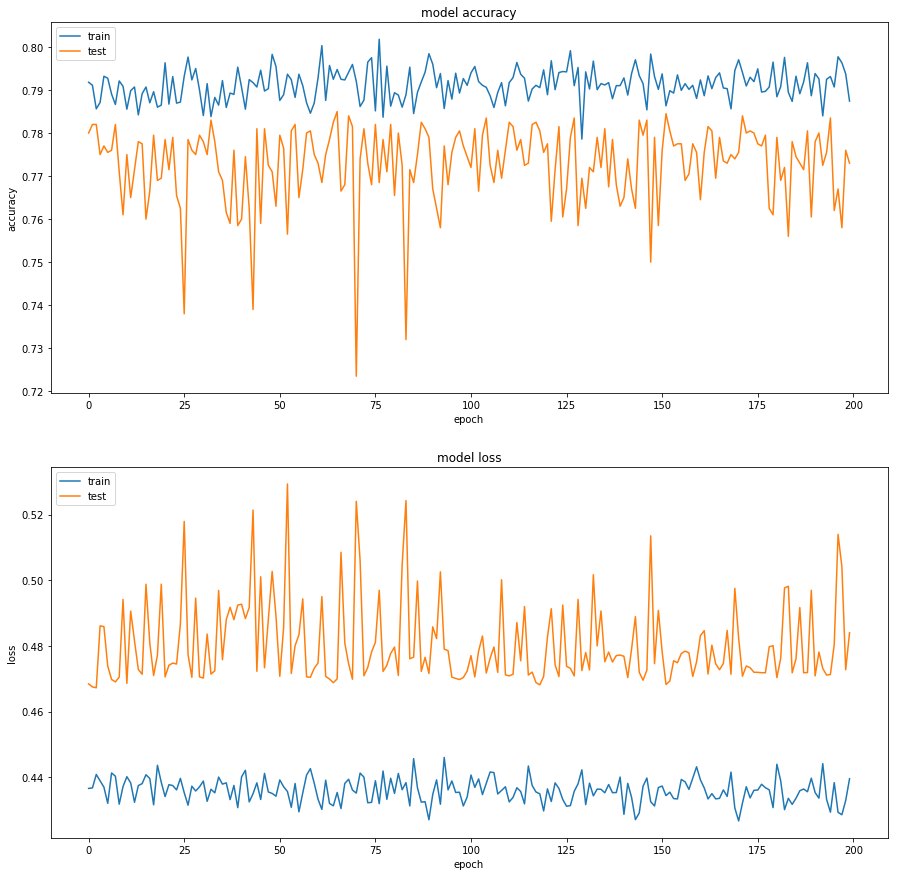

In [50]:
plot_performance(inception_history)

In [51]:
inception_model.load_weights('weights.best.inception.hdf5')

malawi_inception_predictions = [np.argmax(inception_model.predict(np.expand_dims(tensor, axis=0))) for tensor in inception_test]
inception_predictions = inception_model.predict(inception_test)
test_accuracy = 100*np.sum(np.array(malawi_inception_predictions)==np.argmax(malawi_test_targets, axis=1))/len(malawi_inception_predictions)
log_loss = metrics.log_loss(y_pred=inception_predictions, y_true=malawi_test_targets)

print('Test accuracy: %.4f%%' % test_accuracy)
print('Log loss: %.4f' % log_loss)

Test accuracy: 74.8750%
Log loss: 0.5078


## VGG-16 Model

This process is similar to that of the InceptionV3 process, since they are both transfer learning methods. We will import the pre-trained model on ImageNet data and apply to our Malawi images to extract, save, and load our bottleneck features.

In [22]:
from keras.applications import VGG16

In [12]:
base_model = VGG16(include_top=False, weights='imagenet')

In [13]:
from keras.utils import plot_model
plot_model(model1, to_file='vgg16_model.png')

In [71]:
train = base_model.predict(malawi_train_tensors)
valid = base_model.predict(malawi_valid_tensors)
test = base_model.predict(malawi_test_tensors)

In [72]:
np.savez(file='vgg16_features', 
         train=train, 
         valid=valid,
         test=test)

In [25]:
bottleneck_features = np.load('vgg16_features.npz')
train_vgg16 = bottleneck_features['train']
valid_vgg16 = bottleneck_features['valid']
test_vgg16 = bottleneck_features['test']

The shape of our VGG-16 bottleneck features is slightly different than our IncpetionV3 shape. This is largely a result of the different number of layers used in each model. The VGG-16 model uses 16 fully connected layers (hence the name) while the InceptionV3 model uses much more complexity.

In [27]:
train_vgg16.shape

(6400, 8, 8, 512)

In [33]:
vgg16_model = Sequential()
vgg16_model.add(GlobalAveragePooling2D(input_shape=train_vgg16.shape[1:]))
vgg16_model.add(Dropout(0.2))
vgg16_model.add(Dense(2, activation='sigmoid'))

vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


As mentioned before, parameter tuning is key for transfer learning:

In [75]:
rmsprop = optimizers.RMSprop(lr = 0.001)
vgg16_model.compile(loss = "binary_crossentropy", 
                    optimizer = rmsprop, 
                    metrics=["accuracy"])

epochs=200
batch_size=126

In [76]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='weights.best.vgg16.hdf5', 
                               verbose=1, save_best_only=True)

vgg16_history = vgg16_model.fit(train_vgg16, malawi_train_targets, 
          validation_data=(valid_vgg16, malawi_valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6400 samples, validate on 1000 samples
Epoch 1/200
6400/6400 [==============================] - 1s 87us/step - loss: 0.6279 - acc: 0.6473 - val_loss: 0.5712 - val_acc: 0.7360
Epoch 2/200
6400/6400 [==============================] - 0s 65us/step - loss: 0.5662 - acc: 0.7184 - val_loss: 0.5366 - val_acc: 0.7430
Epoch 3/200
6400/6400 [==============================] - 0s 65us/step - loss: 0.5359 - acc: 0.7411 - val_loss: 0.5217 - val_acc: 0.7510
Epoch 4/200
6400/6400 [==============================] - 0s 62us/step - loss: 0.5273 - acc: 0.7470 - val_loss: 0.5146 - val_acc: 0.7520
Epoch 5/200
6400/6400 [==============================] - 0s 64us/step - loss: 0.5187 - acc: 0.7486 - val_loss: 0.5097 - val_acc: 0.7530
Epoch 6/200
6400/6400 [==============================] - 0s 64us/step - loss: 0.5166 - acc: 0.7517 - val_loss: 0.5070 - val_acc: 0.7550
Epoch 7/200
6400/6400 [==============================] - 0s 62us/step - loss: 0.5113 - acc: 0.7533 - val_loss: 0.5076 - val_acc: 0.7490


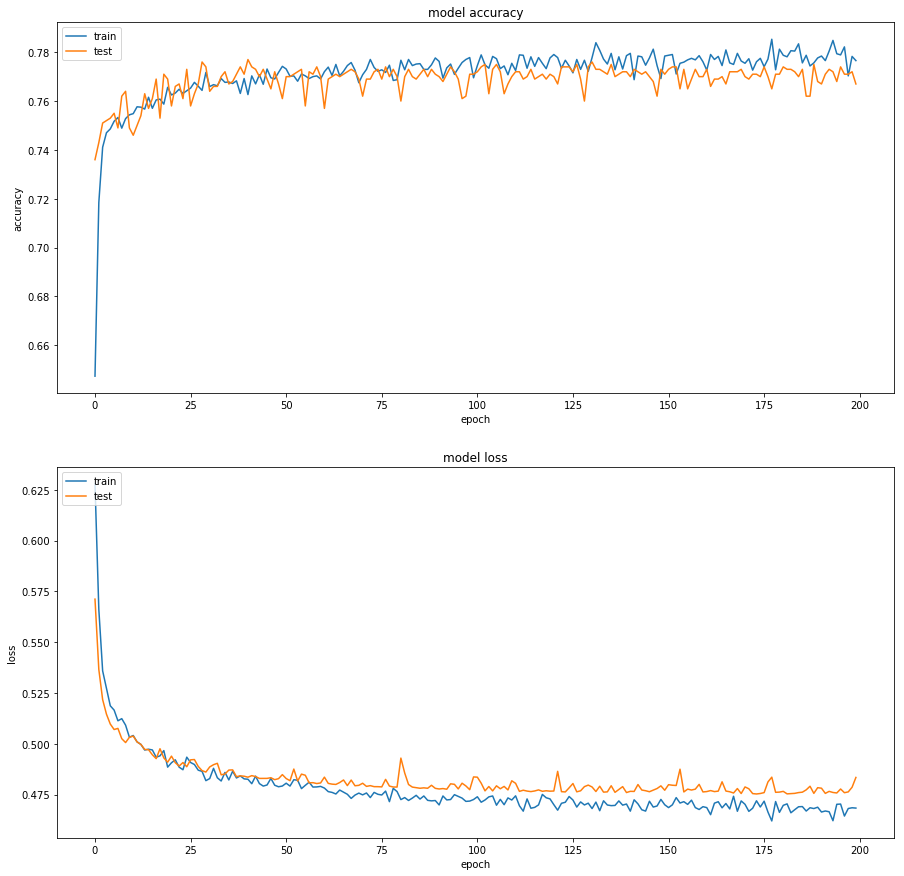

In [77]:
plot_performance(vgg16_history)

In [34]:
vgg16_model.load_weights('weights.best.vgg16.hdf5')

malawi_vgg16_predictions = [np.argmax(vgg16_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_vgg16]
vgg16_predictions = vgg16_model.predict(test_vgg16)
test_accuracy = 100*np.sum(np.array(malawi_vgg16_predictions)==np.argmax(malawi_test_targets, axis=1))/len(malawi_vgg16_predictions)
log_loss = metrics.log_loss(y_pred=vgg16_predictions, y_true=malawi_test_targets)

print('Test accuracy: %.4f%%' % test_accuracy)
print('Log loss: %.4f' % log_loss)

Test accuracy: 75.6250%
Log loss: 0.5064


## Prediction analysis

I will choose to explore the VGG-16 model's performance further. This will require some data manipulation to fit into our metric functions, such as producing a confusion matrix:

In [35]:
np.argmax(malawi_test_targets, axis=1)

array([0, 1, 0, ..., 0, 1, 1])

In [55]:
threshold = 0.5
baseline_predictions_binary = (baseline_predictions_array < threshold).astype(np.int)
baseline_predictions_list = np.array(pd.DataFrame(baseline_predictions_binary)[0])

In [56]:
malawi_vgg16_predictions = (vgg16_model.predict(test_vgg16) > 0.5).astype(np.int)
malawi_vgg16_predictions = np.array(pd.DataFrame(malawi_vgg16_predictions)[0])

In [57]:
malawi_test_array = np.array(pd.DataFrame(malawi_test_targets)[0]).astype(np.int)

In [58]:
vgg16_results = malawi_test_array == malawi_vgg16_predictions
vgg16_incorrect = np.where(vgg16_results==False)[0]
vgg16_incorrect_sample = np.random.choice(vgg16_incorrect,size=5)

Our VGG-16 model's confusion matrix can be found below.

In [59]:
vgg16_matrix = metrics.confusion_matrix(y_true=malawi_test_array, y_pred=malawi_vgg16_predictions)
tn, fp, fn, tp = metrics.confusion_matrix(y_true=malawi_test_array, y_pred=malawi_vgg16_predictions).ravel()
vgg16_matrix

array([[686, 126],
       [264, 524]])

Now we will take a subset of some incorrectly predicted images from our test set:

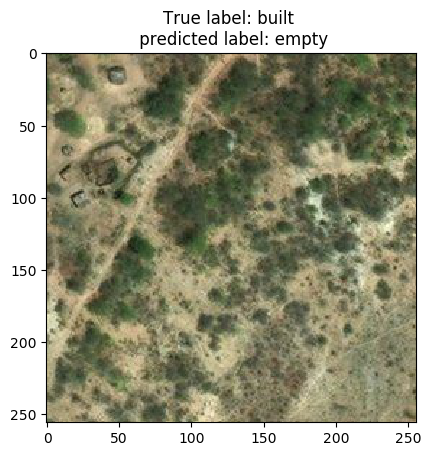

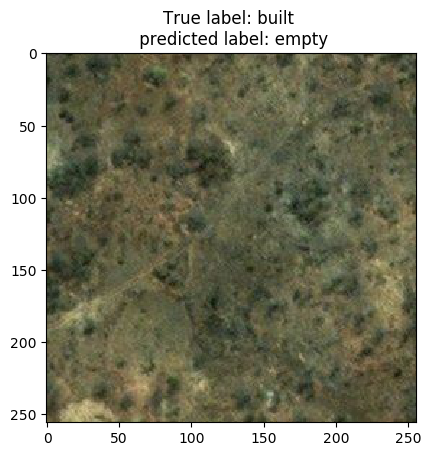

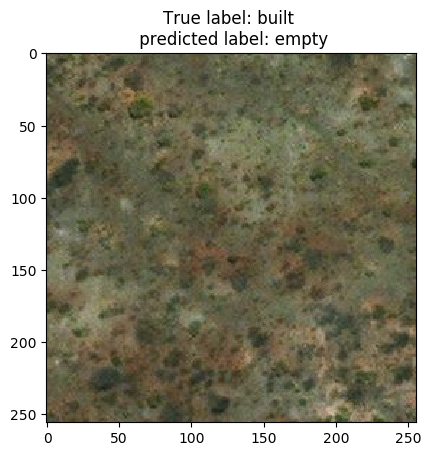

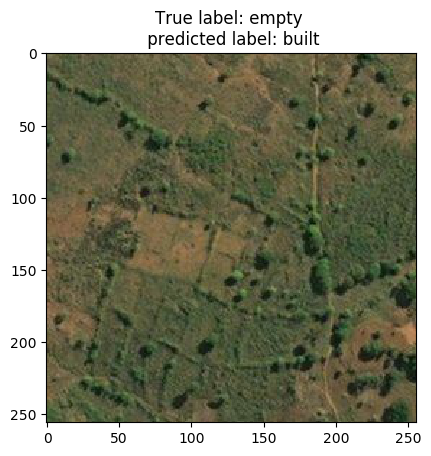

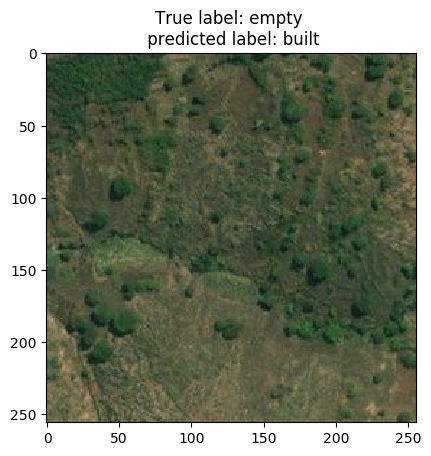

In [60]:
for i,sample in enumerate(vgg16_incorrect_sample):
    if malawi_test_array[sample] == 0:
        true = "empty"
    else:
        true = "built"
    if malawi_vgg16_predictions[sample] == 0:
        pred = "empty"
    else:
        pred = "built"
    img = image.load_img(malawi_test_files[sample],target_size = (256,256))
    fig = plt.figure()
    plt.title("True label: {} \n predicted label: {}".format(true,pred))
    plt.imshow(img)
plt.show()